In [84]:
import os
import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import pickle
import time
import matplotlib.pyplot as plt
import collections
from dateutil.parser import parse
import seaborn as sns

# 1. Data

In order to create our graph, we first performed some preprocessing on the three dataframes we downloaded.
Specifically, the function load_dfs, checks if the processed dataframes already exist: if they do, it simply loads them, otherwise it performs the following steps on the raw txt files:

1. Converts the time from the UNIX format to datetime.<br><br>

2. Filters the dataframe in order to take only the entries more recent than the given threshold date.<br><br>

3. Performs min-max scaling on the unix time, and put the scaled values in a column called weights. It's important    to specify that what we actually implemented is the opposite of the traditional min-max scaling: rather than           measuring the distance from the minimum and dividing it by the interval between minimum and maximum, we're             taking the distance from the maximum in the numerator. This allows us to have higher weights (i.e. higher             distances) for less recent interactions and smaller weights for the more recent ones. The idea is to penalize         less recent entries.<br><br>

4. Save the files as binary pickle files.<br><br>

In [56]:
def load_dfs(threshold):
    
    if "df_a2q" not in os.listdir("files") \
    or "df_c2q" not in os.listdir("files") \
    or "df_c2a" not in os.listdir("files"):
    
        file_names = ["files/sx-stackoverflow-a2q.txt",
                      "files/sx-stackoverflow-c2q.txt",
                      "files/sx-stackoverflow-c2a.txt"]

        columns = [["user_answering", 
                    "user_questioning", 
                    "time_u"],
                   ["user_commenting", 
                    "user_questioning", 
                    "time_u"],
                   ["user_commenting", 
                    "user_answering", 
                    "time_u"]]

        df_a2q_raw = pd.read_csv(file_names[0],
                                 delim_whitespace=True,
                                 names=columns[0])

        df_c2q_raw = pd.read_csv(file_names[1],
                                 delim_whitespace=True,
                                 names=columns[1])

        df_c2a_raw = pd.read_csv(file_names[2],
                                 delim_whitespace=True,
                                 names=columns[2])
        
        
        dfs_raw = [df_a2q_raw, df_c2q_raw, df_c2a_raw]

        print(df_a2q_raw.shape)

        # add a column for a standard visualization of dates
        for df in dfs_raw:
            df["time_h"] = pd.to_datetime(df["time_u"], unit="s")

        names = ["a2q", "c2q", "c2a"]
        for i, df in enumerate(dfs_raw):
            most_recent = df["time_h"].max()
            name = names[i]
            print(f"Most recent date for dataset {name}: {most_recent}")

        print(f"Date threshold selected: {threshold}")

        df_a2q = df_a2q_raw[df_a2q_raw["time_h"] > threshold].copy()
        df_c2q = df_c2q_raw[df_c2q_raw["time_h"] > threshold].copy()
        df_c2a = df_c2a_raw[df_c2a_raw["time_h"] > threshold].copy()

        dfs = [df_a2q, df_c2q, df_c2a]
        for df in dfs:
            min_el = df["time_u"].min()
            max_el = df["time_u"].max()
            
            # variation on min max scaler so to have values closer to the max -> to 0 and values
            # closer to the min -> to 1.
            df["weight"] = (max_el - df["time_u"]) / (max_el - min_el)
            
            df.drop("time_u", inplace=True, axis=1)

        with open("files/df_a2q", "wb") as file:
            pickle.dump(df_a2q, file)

        with open("files/df_c2q", "wb") as file:
            pickle.dump(df_c2q, file)

        with open("files/df_c2a", "wb") as file:
            pickle.dump(df_c2a, file)
    
    else:
        
        with open("files/df_a2q", "rb") as file:
            df_a2q = pickle.load(file)
        
        with open("files/df_c2q", "rb") as file:
            df_c2q = pickle.load(file)
            
        with open("files/df_c2a", "rb") as file:
            df_c2a = pickle.load(file)
    
    return df_a2q, df_c2q, df_c2a

In [57]:
names = ["a2q", "c2q", "c2a"]

In [58]:
threshold = datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0)
df_a2q, df_c2q, df_c2a = load_dfs(threshold=threshold)

Once we're finished, we obtain the following general structure for each dataframe:

In [59]:
df_a2q.head()

,user_answering,user_questioning,time_h,weight
10861428,95190,960750,2014-01-01 00:00:05,1.0
10861429,607314,2635650,2014-01-01 00:00:12,1.0
10861430,301857,1549201,2014-01-01 00:00:16,1.0
10861431,1419954,1897577,2014-01-01 00:00:21,1.0
10861432,254252,3065375,2014-01-01 00:00:23,1.0


In [60]:
df_c2q.head()

,user_commenting,user_questioning,time_h,weight
9576868,976391,3061211,2014-01-01 00:00:08,1.0
9576869,445131,2489834,2014-01-01 00:00:24,1.0
9576870,1832636,2721870,2014-01-01 00:00:27,1.0
9576871,822711,3136232,2014-01-01 00:00:28,1.0
9576872,22656,1693074,2014-01-01 00:00:34,1.0


In [61]:
df_c2a.head()

,user_commenting,user_answering,time_h,weight
14958295,22656,22656,2014-01-01 00:00:08,1.0
14958296,2224701,23385,2014-01-01 00:00:14,1.0
14958297,2732801,2732801,2014-01-01 00:00:21,1.0
14958298,1965449,2325987,2014-01-01 00:00:22,1.0
14958299,26742,26742,2014-01-01 00:00:23,1.0


We create a list containing the three dataframes since it will make it easier to process the data within.

In [62]:
dfs = [df_a2q,
       df_c2q,
       df_c2a]

First, we implement two utility functions:

1. ***time_wrapper*** is a very simple decorator that was useful to time our implementations.<br><br>

2. ***visualize network*** uses the functionalities contained in the library networkX to visualize specific subgraphs. It takes as argument the graph to plot and a list containing the edges we want to highlight. If this last parameter is not provided, all the edges will be black. 

In [63]:
def time_wrapper(func):
    """
    Summary:
        Decorator to time functions. A print statement containing the running time of the function will be printed.
    
    Args:
        the function that has to be decorated.
    """
    def wrapped(*args, **kwargs):
        start = time.time()
        r = func(*args, **kwargs)
        print(f"Time elapsed: {time.time()-start}")
        return r
    return wrapped


def visualize_network(graph:dict, 
                      edges_to_highlight:list=[], 
                      nodes_to_highlight:list=[], 
                      nodes_to_label:list=[], 
                      alpha:float=0.2, 
                      label_c:str="yellow"):
    
    """
    Summary:
        Visualizes a graph using the networkX module. If edges_to_highlight is provided, it highlights in red
        the desired edges.
    
    Args:
        graph(dict): a dictionary representing the graph to be plotted.
        edges_to_highlight: the edges that have to be highlighted.
        alpha: the transparency value for the edges that are not to be highlighted.
        highlight_nodes: a boolean signaling whether we also want the nodes corresponding to the highlighted edges
                         to be highlighted.
    
    """
    
    nx_g = nx.MultiDiGraph(graph)
    black_edges = [edge for edge in nx_g.edges() if edge not in edges_to_highlight]
    blank_nodes = [node for node in nx_g.nodes() if node not in nodes_to_highlight]
    
    plt.figure(figsize=(30, 20))
    pos = nx.spring_layout(nx_g)
    
    if len(nodes_to_label) > 0:
        labels_d = {node: "" for node in nx_g.nodes}
        for label in nodes_to_label:
            labels_d[label] = str(label)
        
        nx.draw_networkx_labels(nx_g,
                            pos,
                            labels_d,
                            font_size=16,
                            font_weight="bold",
                            font_color=label_c)
    
    nx.draw_networkx_nodes(nx_g,
                           pos, 
                           cmap=plt.get_cmap('jet'), 
                           node_size = 200, 
                           nodelist=nodes_to_highlight, 
                           node_color="g")

    nx.draw_networkx_nodes(nx_g, 
                           pos, 
                           cmap=plt.get_cmap('jet'), 
                           node_size = 200, 
                           nodelist=blank_nodes, 
                           alpha=alpha)
    
    nx.draw_networkx_edges(nx_g, 
                           pos, 
                           edgelist=edges_to_highlight, 
                           edge_color='r',
                           width=5.0,
                           arrows=True)
    
    nx.draw_networkx_edges(nx_g, 
                           pos, 
                           edgelist=black_edges, 
                           alpha=alpha, 
                           arrows=True)

    
    plt.show()

Next, we created our Graph class. For what concerns the underlying data structure, we decided to implement a dictionary of dictionaries (of dictionaries of dictionaries). <br>There are mainly two reason for this choice:<br><br>
1. First, with dictionaries accessing the details for each edge is extremely fast and convenient, while with other data structure we would have probably needed several loops for many operations.<br><br>
2. this implementation is similar to the one used by networkX and this has allowed us to use seamlessly the visualization functions contained in that library.<br><br>

For what concerns the class function itself, we implemented a ***create_graph*** method that builds the graph according to the following structure:

**self.graph** -> Our entire graph, indexed by node.<br><br>
**self.graph[node "A"]** -> dictionary indexed by the neighbors of "A".<br><br>
**self.graph[node "A"][node "B"]** -> dictionary indexed by the time the interation took place.<br><br>
**self.graph[node "A"][node "B"][time "x"]** -> final dictionary with details (specifically type of interaction and edge weight) of the interaction between user A and B that took place at time x.<br><br>

Since this process takes about 90 minutes to complete, we created a ***save_graph*** function and a ***load_graph*** function to avoid having to recreate the graph each time.

We also created a ***get_random_subgraph*** method that, starting from a random node, walks the graph and returns us a subgraph. This was mainly done to test our functionalities on a lighter, less cumbersome graph.

In [72]:
class Graph:
    
    def __init__(self):
        self.graph = {}
                
    
    @time_wrapper
    def create_graph(self, sources, names):
        """
        Args:
            sources: dataframes from which to create the graph
            names: a list of string containing the names of the graph used in order to label the edges accordingly
        
        Summary:
            Creates a graph with the following structure:
            
            self.graph -> Our entire graph, indexed by node
            self.graph[node "A"] -> dictionary indexed by the neighbors of "A"
            self.graph[node "A"][node "B"] -> dictionary indexed by the time the interation took place
            self.graph[node "A"][node "B"][time "x"] -> details (specifically, type of interaction and edge weight) of the
                                                        of the interaction between user A and B that took place at time x            
        """
        
        self.graph = {}
    
        for i_source, source in enumerate(sources):
            nodes_column = source.iloc[:, 0]
            nodes = nodes_column.unique()
            type_of_interaction = names[i_source]
            
            for node in tqdm(nodes):
                if node not in self.graph.keys():
                    self.graph[node] = {}
                # take the subset of the dataframe of the entries for "node"
                node_subdf = source[nodes_column == node]
                neighbors = node_subdf.iloc[:, 1].values
                times_h = node_subdf.iloc[:, 2].values
                weights = node_subdf.iloc[:, 3].values
                for i, neighbor in enumerate(neighbors):
                    # Here we want to make sure that even if a node figures only as a neighbor, it still exists as 
                    # a node in our graph.
                    if neighbor not in self.graph.keys(): 
                        self.graph[neighbor] = {}
                    if neighbor not in self.graph[node].keys():
                        self.graph[node][neighbor] = {}
                        
                    self.graph[node][neighbor][times_h[i]] = {"weight": weights[i], 
                                                              "type_of_interaction": type_of_interaction}
        
    
    @time_wrapper
    def save_graph(self, path):
        """
        Args:
            path: name of file where we want the file stored
        Summary:
            Saves graph as a binary file.
        """
        
        with open(path, "wb") as file:
            pickle.dump(self.graph, file)

    
    @time_wrapper
    def load_graph(self, path):
        """
        Args:
            path: name of file to load the graph from.
        Summary:
            Load graph from binary file.
        """
        
        with open(path, "rb") as file:
            self.graph = pickle.load(file)
    
    
    def get_random_subgraph(self, n_nodes=100000):
        np.random.seed(42)
        bad_starting_node = True
        while bad_starting_node:
            random_node = np.random.choice(list(self.graph.keys()))
            if len(self.graph[random_node].keys()) > 10:
                bad_starting_node = False
        print(f"Starting node: {random_node}")
        print(f"Degree of starting node: {len(self.graph[random_node].keys())}")
        subgraph = {random_node: {}}
        to_check = [random_node]
        i = 0
        
        while len(subgraph.keys()) < n_nodes:
            node = to_check[i]
            if node not in subgraph.keys() or len(subgraph[node].keys()) < 1:
                for neighbor in self.graph[node].keys():
                    if neighbor not in to_check:
                        to_check.append(neighbor)
                    if neighbor not in subgraph.keys():
                        subgraph[neighbor] = {}
                    subgraph[node][neighbor] = self.graph[node][neighbor]
                    if len(subgraph.keys()) >= n_nodes:
                        break
            i += 1
        
        return subgraph
    
    
    def get_neighbors(self, node, interaction="all"):
        """
        Args:
            node: the node we want the neighbors of.
            interaction: the label of the edges we're interested in, default=all, meaning we will obtain all
                         neighbors of that node, regardless of the type of interactions.
        Summary:
            Obtains all the neighbors of a specific node.
        """
        
        if interaction == "all":
            neighbors = list(self.graph[node].keys())
        else:
            neighbors = []
            for neighbor in self.graph[node].keys():
                for time_key in self.graph[node][neighbor].keys():
                    if self.graph[node][neighbor][time_key]["type_of_interaction"] == interaction:
                        # Once we found even one instance in which the two users have interacted in the way 
                        # we're interested in, we can consider them neighbors for what concerns that interaction
                        neighbors.append(neighbor)
                        break
        
        return neighbors
    
    
    def get_part(self, interaction):
        new_graph = {}
        for node in self.graph.keys():
            for neighbor in self.graph[node].keys():
                for time_key in self.graph[node][neighbor].keys():
                    if self.graph[node][neighbor][time_key]["type_of_interaction"] == interaction:
                        if node in self.graph[neighbor].keys():
                            inside = False
                            for time_key2 in self.graph[neighbor][node].keys():
                                if self.graph[neighbor][node][time_key2]["type_of_interaction"] == interaction:
                                    inside = True
                                    break
                            if inside:
                                if node not in new_graph.keys(): 
                                    new_graph[node] = {}
                                if neighbor not in new_graph[node].keys():
                                    new_graph[node][neighbor] = {}

                                new_graph[node][neighbor][time_key] = self.graph[node][neighbor][time_key]
                                
        g = Graph()
        g.graph = new_graph
        return g

Finally, we build our graph. (or load it if we have already built it).

In [75]:
g = Graph()

if "merged_graph.p" in os.listdir("files"):
    g.load_graph("files/merged_graph_2.p")
else:
    g.create_graph(dfs, names=names)
    g.save_graph("files/merged_graph.p")

Time elapsed: 378.28904485702515


If we need a smaller subgraph, we can also load a lighter version made of just 100000 nodes, created with the get_random_subgraph method.

In [73]:
# This for lightweight graph

g = Graph()
g.load_graph("files/merged_graph_lw_2.p")

Time elapsed: 1.2878830432891846


# 2. Implementation of the backend

## Functionality 1

In [79]:
def overallFeatures(g : Graph):
    directed = False
    nodes = g.graph.keys()
    ncoment = 0
    for node in nodes:
        nes = g.graph[node].keys()
        ncoment += len(nes)
        if directed:
            continue
        for ne in nes:
            if not node in g.graph[ne].keys():
                directed = True
                break
    if not directed:
        v1 = ('This graph is not directed')
        v2 = ('This graph has '+ str(len(nodes)) + ' users')
        v3 = ('This graph has ',str(ncoment/2),' answers/comments')
        v4 = ('This graph has on average '+ str((ncoment/2)/len(nodes))+ ' link per user')
    else:
        v1 = ('This graph is directed')
        v2 = ('This graph has '+ str(len(nodes))+' users')
        v3 = ('This graph has '+str(ncoment)+' answers/comments')
        v4 = ('This graph has on average ', str(ncoment/len(nodes)), ' link per user')
    d = ncoment/(len(nodes)*(len(nodes) - 1))
    v5 = ('The graph density is '+ str(d))
    if d < .5:
        v6 = ('The graph is Sparse')
    else:
        v6 = ('The graph is dense')    
    ans = pd.DataFrame({'answers' : [v1, v2, v3, v4, v5, v6]})
    de = [len(g.get_neighbors(node)) for node in nodes]
    return ans, de

In [81]:
ans, de = overallFeatures(g)
print(ans)

                                             answers
0                             This graph is directed
1                       This graph has 1804839 users
2           This graph has 15861610 answers/comments
3  (This graph has on average , 8.788379462101606...
4         The graph density is 4.869345316367234e-06
5                                The graph is Sparse


In [82]:
gf1 = g.get_part('c2a') # As we want to evalute only 1 of the 3 graph
table, alld = overallFeatures(gf1)
table

,answers
0,This graph is not directed
1,This graph has 279686 users
2,"(This graph has , 198660.0, answers/comments)"
3,This graph has on average 0.7102965468418154 l...
4,The graph density is 5.079260931703992e-06
5,The graph is Sparse


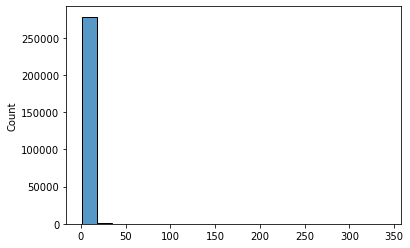

In [85]:
sns.histplot(alld)
plt.show()

## Functionality 2

In [90]:
def selecttime(gr, time: tuple):
    """
    Selects a subgraph that whose entries are within the time interval
    :param gr:       initial graph
    :param time:     tuple (start time, end time) in yyyy-mm-dd format
    :returns:        subgraph whose edges are in the time interval
    """
    all_neighbors = set()
    keys_to_remove = []
    for key in list(gr.graph.keys()):
        stuffs_to_remove = []
        for stuff in list(gr.graph[key].keys()): ## gr.get_neighbors(key)
            time_keys_to_remove = []
            for time_key in gr.graph[key][stuff].keys():
                timegraph = str(time_key)
                truetime = datetime.strptime(timegraph[:10], "%Y-%m-%d")
                start = datetime.strptime(time[0], "%Y-%m-%d")
                end = datetime.strptime(time[1], "%Y-%m-%d")
                if not (truetime > start and truetime < end):
                    time_keys_to_remove.append(time_key)
            for time_key in time_keys_to_remove:
                gr.graph[key][stuff].pop(time_key)
            if len(gr.graph[key][stuff]) <= 0:
                stuffs_to_remove.append(stuff)
            else:
                all_neighbors.add(stuff)
                
        for stuff in stuffs_to_remove:
            gr.graph[key].pop(stuff)
        
        # If they're empty but they still figure as neighbors for some other node, we need to keep them
        if len(gr.graph[key]) <= 0 and key not in all_neighbors:
            keys_to_remove.append(key)
    
    for key in keys_to_remove:
        gr.graph.pop(key)
        
    return gr


def matrixfromgraph(gr, node):
    """
    Creates adjacency matrix normalized over rows
    :param:       graph
    :returns:     adjacency matrix and the index of the node I want the PageRank
                  score of
    """
    keys = list(gr.graph.keys())
    ris = np.zeros((len(keys), len(keys)))
    for i in range(len(keys)):
        if keys[i] == node:
            node_ind = i
        for j in range(len(keys)):
            if keys[j] in gr.graph[keys[i]]:
                for tup in gr.graph[keys[i]][keys[j]]:
                    ris[i][j] += gr.graph[keys[i]][keys[j]][tup]['weight']
        if np.sum(ris[i]):
            ris[i] /= np.sum(ris[i])
    return node_ind, ris


def shortlength(gr, start, end):
    """
    finds the shortest path from one node to another using a mechanism similar to dijsktra's algorithm 
    keeping info on the nodes that lead to the path
    :param gr:      graph
    :param start:   starting node
    :param end:     end node
    :returns:       list of ordered nodes in the shortest path
    
    """
    # Here I create a dictionary that contains the distances of every node from 
    # the start and tells me how to get there 
    dic = distances(gr, start)
    path = []
    current = end
    # In this cycle I work my way backwards from the end point to the start
    while current is not None:
        path.append(current)
        if current in dic.keys():
            app = dic[current][0]
            current = app
        else:   
            # returns empty list if path does not exist
            # (it should, since we are considering cc of the graph)
            print('Attention')
            return [] 
    path = path[::-1]
    return path


def component(gr, node):
    # keep an eye on the duplicates in to_do
    """ 
    Returns the connected component of the graph gr that contains the node 
    (if edges spawn from it)
    :param gr: the graph
    :param node: the node that we are interested in
    :returns 
    """
    ris = Graph()
    vis = set()
    current = node
    if node not in gr.graph.keys():
        return ris
    to_do = {i for i in gr.get_neighbors(node)}
    # Here I add to the new graph all the nodes that I can visit
    while len(to_do):
        vis.add(current)
        if current in gr.graph.keys():
            ris.graph[current] = {}
            for edge in gr.graph[current].keys():
                ris.graph[current][edge] = gr.graph[current][edge]
                if edge not in vis:
                    to_do.add(edge)
        current = to_do.pop()
    return ris
  
    
def distances(gr, start):
    """
    Returns a dictionary whose values indicate the total distance from the starting
    node and the node that precedes them in the shortest path
    :param gr:     the graph that is being considered
    :param start:  the starting node
    :returns:      dictionary in the form dic[key] = (preceding_node, start-key distance)
    """
    # I initialize a dictionary that will be in the form dic[key] = (preceding_node, start-key distance)
    # in the starting position the preceding node will be None
    dic = {start: (None, 0)} 
    current = start
    vis = set()
    new = {node: dic[node] for node in dic if node not in vis}
    while True:
        vis.add(current)
        if current in gr.graph.keys(): # Nodes that are reachable may not have any edge spawning!
            neighbors = gr.get_neighbors(current)
            len_so_far = dic[current][1]
            for node in neighbors:
                # Since I look for the shortest path I will always travel on the lightest edge
                newweight = min([gr.graph[current][node][time_key]["weight"]
                                 for time_key in gr.graph[current][node].keys()])
                weight = newweight + len_so_far
                if node not in dic:
                    dic[node] = (current, weight)
                else:
                    current_shortest_weight = dic[node][1]
                    if current_shortest_weight > weight:
                        dic[node] = (current, weight)      
            new = {node: dic[node] for node in dic if node not in vis}
        else:
            new.pop(current)
        if not new:
                return dic
        current = min(new, key=lambda k: new[k][1])

In [91]:
def functionality_2(user: int, time: tuple, metric: str):
    # Reducing the size of the graph as much as possible
    gapp = copy.deepcopy(g)
    gtime = component(gapp, user)
    gtime = selecttime(gtime, time)
    gtime = component(gtime, user)
    keylist = list(gtime.graph.keys())
    lenlist = len(keylist)
    if metric == 'Betweenness':
        # Starting at -1 because I don't care for the distance between the user and itself
        ris = -1
        # a is the number of total shortest paths
        a = 0
        dicuser = distances(gtime, user)
        gapp = copy.deepcopy(g)
        for i in selecttime(gapp, time).graph.keys():
            # Dictionary of containing the distances between node i and every other node
            gapp2 = copy.deepcopy(g)
            diclen = distances(component(selecttime(gapp2, time), i), i)
            # if the user is not reachable it surely is not in the shortest path
            if user in diclen.keys():
                # nodes that I am considering need to be reachable by both i and user
                for j in set(diclen.keys() and dicuser.keys()):
                    if diclen[j][1] == diclen[user][1] + dicuser[j][1]:
                        ris += 1
            # adding only the number of nodes node i is connected to  
            a += len(list(diclen.keys())) - 1 # Not counting node i itself, hence the -1
        if a == 0:
            return 'There is a problem'
        return ris/a
    if metric == 'PageRank':
        # ind is the index of user in the adjacency matrix M 
        if user not in gtime.graph.keys():
            return 0 
        ind, M = matrixfromgraph(gtime, user)
        vec = np.ones((M.shape[1], 1))/M.shape[1]
        M2 = .85 * M + .15 / M.shape[1]
        for _ in range(100):
            vec = M2 @ vec
        return vec[ind]
    if metric == 'ClosenessCentrality':
        ris = distances(gtime, user)
        dist = np.sum([ris[j][1] for j in ris.keys()])
        if user not in gtime.graph.keys():
            return 0
        if dist == 0:
            return 'There is a problem'
        return (lenlist - 1)/dist
    if metric == 'DegreeCentrality':
        ris = 0
        if user not in gtime.graph.keys():
            return 1
        for i in gtime.graph[user].keys():
            for t in gtime.graph[user][i]:
                ris += len(list(gtime.graph[user][i].keys()))
        return ris

If a node has a high betweenness score, it means that many shortest paths pass though that node. In general if travel or communication is involved it may mean that the node risks becoming overcrowded. In our case it just means that the user is probably very active and interacts with a wide range of users and that the weights are on average small.

If a node has a high page rank it means that a lot of people interact with it or that those who do have themselves a high page rank score. Those with the highest score are probably very active or make questions that generate a lot of debate

If a node has a high closeness centrality score it means that it is on average close to a lot of nodes, this means that it probably interacts with many people or that it's in a (somewhat big) cluster of close users.

If a user has a high degree centrality score it means that the user interacted with many different users. This centrality does not take into account the weight of the interaction

In [ ]:
functionality_2(981959, ("2014-10-03", "2014-10-15"), 'ClosenessCentrality')

### Visualization


In [ ]:
def nodeweights(nodeset, time, metric):
    dic = {}
    for i in tqdm(nodeset):
        dic[i] = functionality_2(i, time, metric)
    return dic

def createnodeset(user, time):
    gapp3 = copy.deepcopy(g)
    gtime = selecttime(gapp3, time)
    ris = gtime.get_neighbors(user)
    ris.append(user)
    return ris

In [246]:
def visualization_2(user: int, time: tuple, metric: str):
    start = datetime.strptime(time[0], "%Y-%m-%d")
    end = datetime.strptime(time[1], "%Y-%m-%d")
    lis = [start + i * (end - start)/4 for i in range(1, 4)]
    for i in range(len(lis)):
        text = 'Node and neighbors between {} and {}'.format(str(lis[i])[:-9], str(end)[:-9])
        print(text)
        timeprev = (str(lis[i])[:-9], str(end)[:-9])
        gapp = copy.deepcopy(g)
        gtime = selecttime(gapp, timeprev)
        if user not in gtime.graph.keys():
             continue
        myset = nodeweights(createnodeset(user, timeprev), timeprev, metric)
        nodes_to_highlight = gtime.get_neighbors(user)
        gtime = {user: gtime.graph[user]}
        nx_g = nx.MultiGraph(gtime)

        size = 100/(min([myset[i] for i in myset.keys()])+1)
        edges = [edge for edge in nx_g.edges() if user in edge]
        plt.figure(figsize=(30, 20))
        pos = nx.spring_layout(nx_g)
    
        nx.draw_networkx_nodes(nx_g, 
                               pos, 
                               cmap=plt.get_cmap('jet'), 
                               node_size = myset[user]*size, 
                               nodelist=[user], 
                               node_color="g")
        for neigh in myset:
            if neigh == user:
                continue
            nx.draw_networkx_nodes(nx_g, 
                                   pos, 
                                   cmap=plt.get_cmap('jet'), 
                                   node_size = myset[neigh]*size, 
                                   nodelist=[neigh])
    
        nx.draw_networkx_edges(nx_g, 
                               pos, 
                               edgelist=edges, 
                               edge_color='r',
                               width=2,
                               arrows=True)
    
    
        plt.show()



100%|█████████████████████████████████████████| 57/57 [1:12:11<00:00, 75.99s/it]


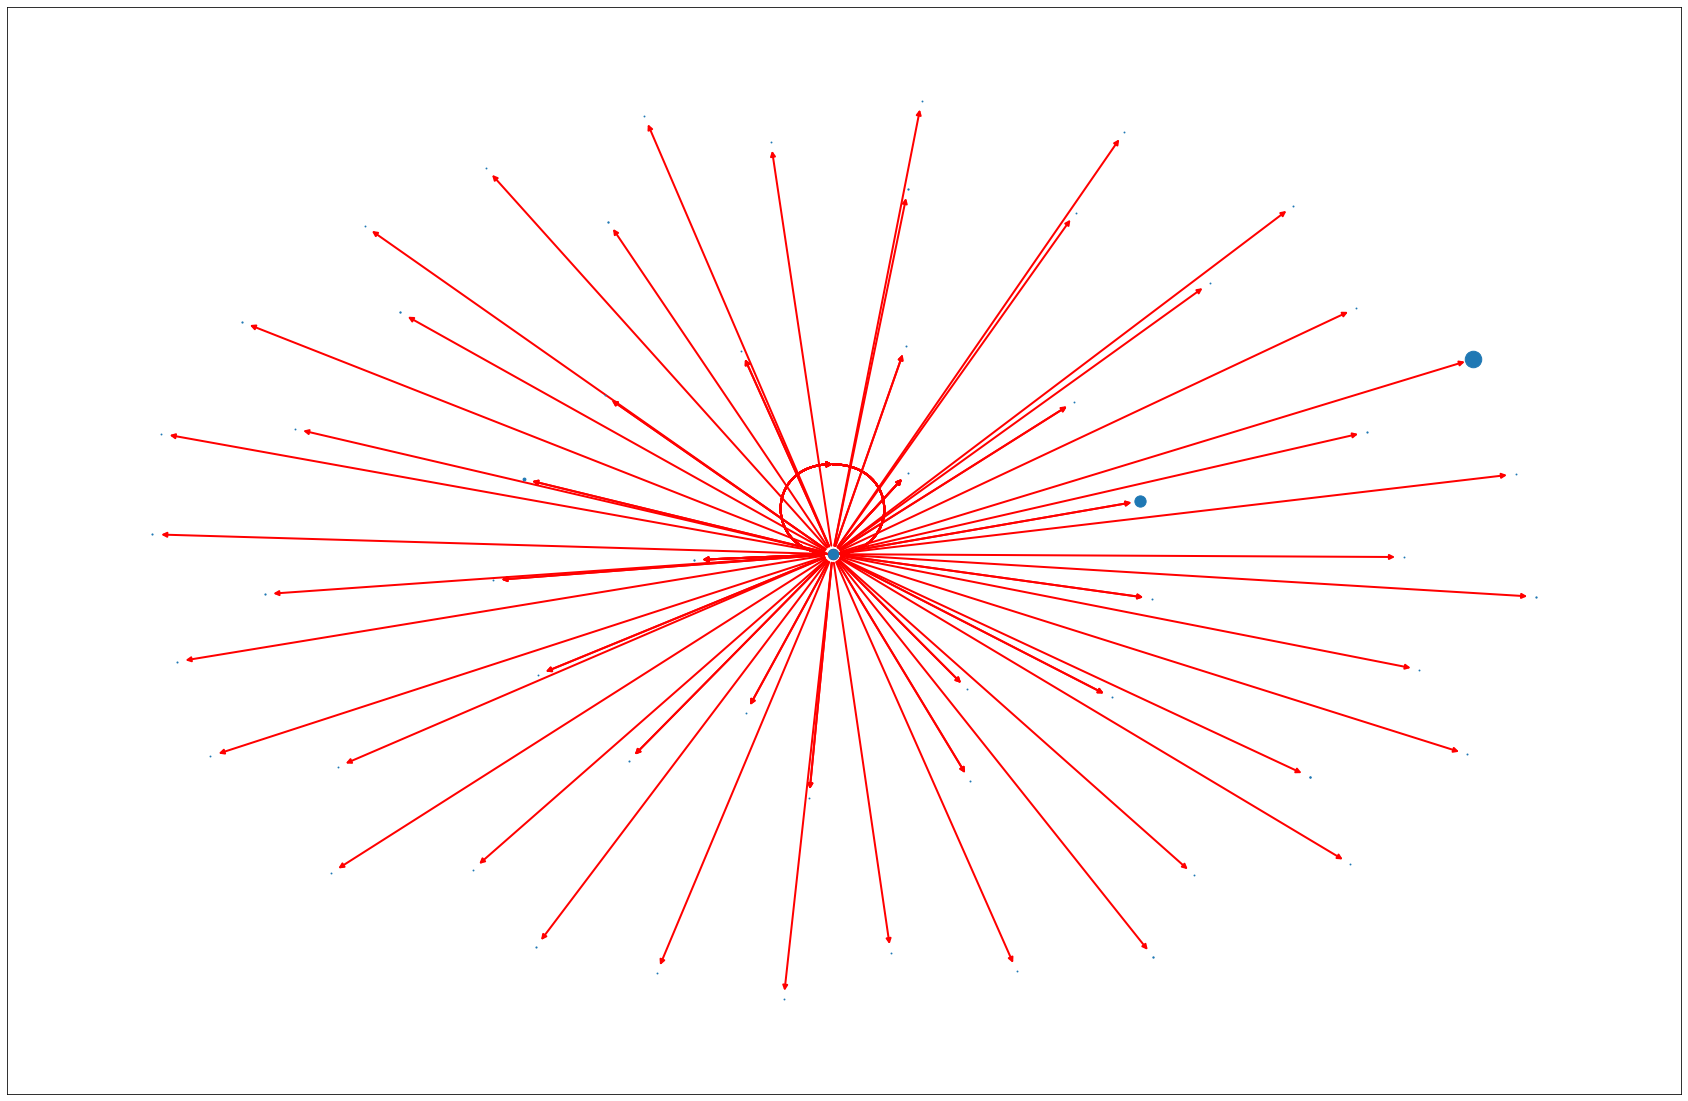

In [57]:
visualization_2(981959, ("2014-10-03", "2014-10-15"), 'ClosenessCentrality')

## Functionality 3 

In order to implement this functionality, we first created a function that performs the dijkstra algorithm and finds the shortest route between two nodes.<br>It then visualizes the shortest route (if the flag visualization is True) and returns both the shortest path and the min_distances matrix used to find it.

In [86]:
def dijkstra(start_node:int, end_node:int, gr:dict, visualization:bool=True):
    """
    Summary:
        Compute the shortest path between start_node and end_node using the dijkstra algorithm.
    
    Args:
        start_node: node from where we want to find the shortest path.
        end_node: node to which we want to find the shortest_path.
        gr: graph containing the nodes.
        visualization: boolean determining whether or not the plot of the graph will be produced.
    """
    unvisited = []
    for key in gr.keys():
        if key not in unvisited:
            unvisited.append(key)
    visited = []

    min_distances = {key: (np.inf, None) for key in gr.keys()}
    min_distances[start_node] = (0, None)

    current_node = start_node

    while current_node != end_node:
        visited.append(current_node)
        unvisited.remove(current_node)
        for neighbor in gr[current_node].keys():
            weights = [gr[current_node][neighbor][time_key]["weight"] for time_key in gr[current_node][neighbor].keys()]
            weight = np.min(weights)
            tot = min_distances[current_node][0] + weight
            if tot < min_distances[neighbor][0]:
                min_distances[neighbor] = (tot, current_node)

        min_unvisited = np.inf
        found_something = False
        for candidate in unvisited:
            if min_distances[candidate][0] < min_unvisited:
                min_unvisited = min_distances[candidate][0]
                current_node = candidate
                found_something = True

        if not found_something:
            break

    node_a = None
    node_b = end_node

    path = []
    while node_a != start_node:
        node_a = min_distances[node_b][1]
        if node_a == None:
            break
        path.append((node_a, node_b))
        node_b = node_a

    if len(path) <= 0:
        print("No path found.")

    else:
        path = path[::-1]
        if visualization:
            visualize_network(gr, 
                              edges_to_highlight=path, 
                              alpha=0.1, 
                              nodes_to_label=[start_node, end_node], 
                              nodes_to_highlight=[start_node, end_node])

    return path, min_distances

We can test this function on a small subgraph of 1000 nodes:

In [49]:
subg = g.get_random_subgraph(n_nodes=1000)

Starting node: 1750757
Degree of starting node: 385


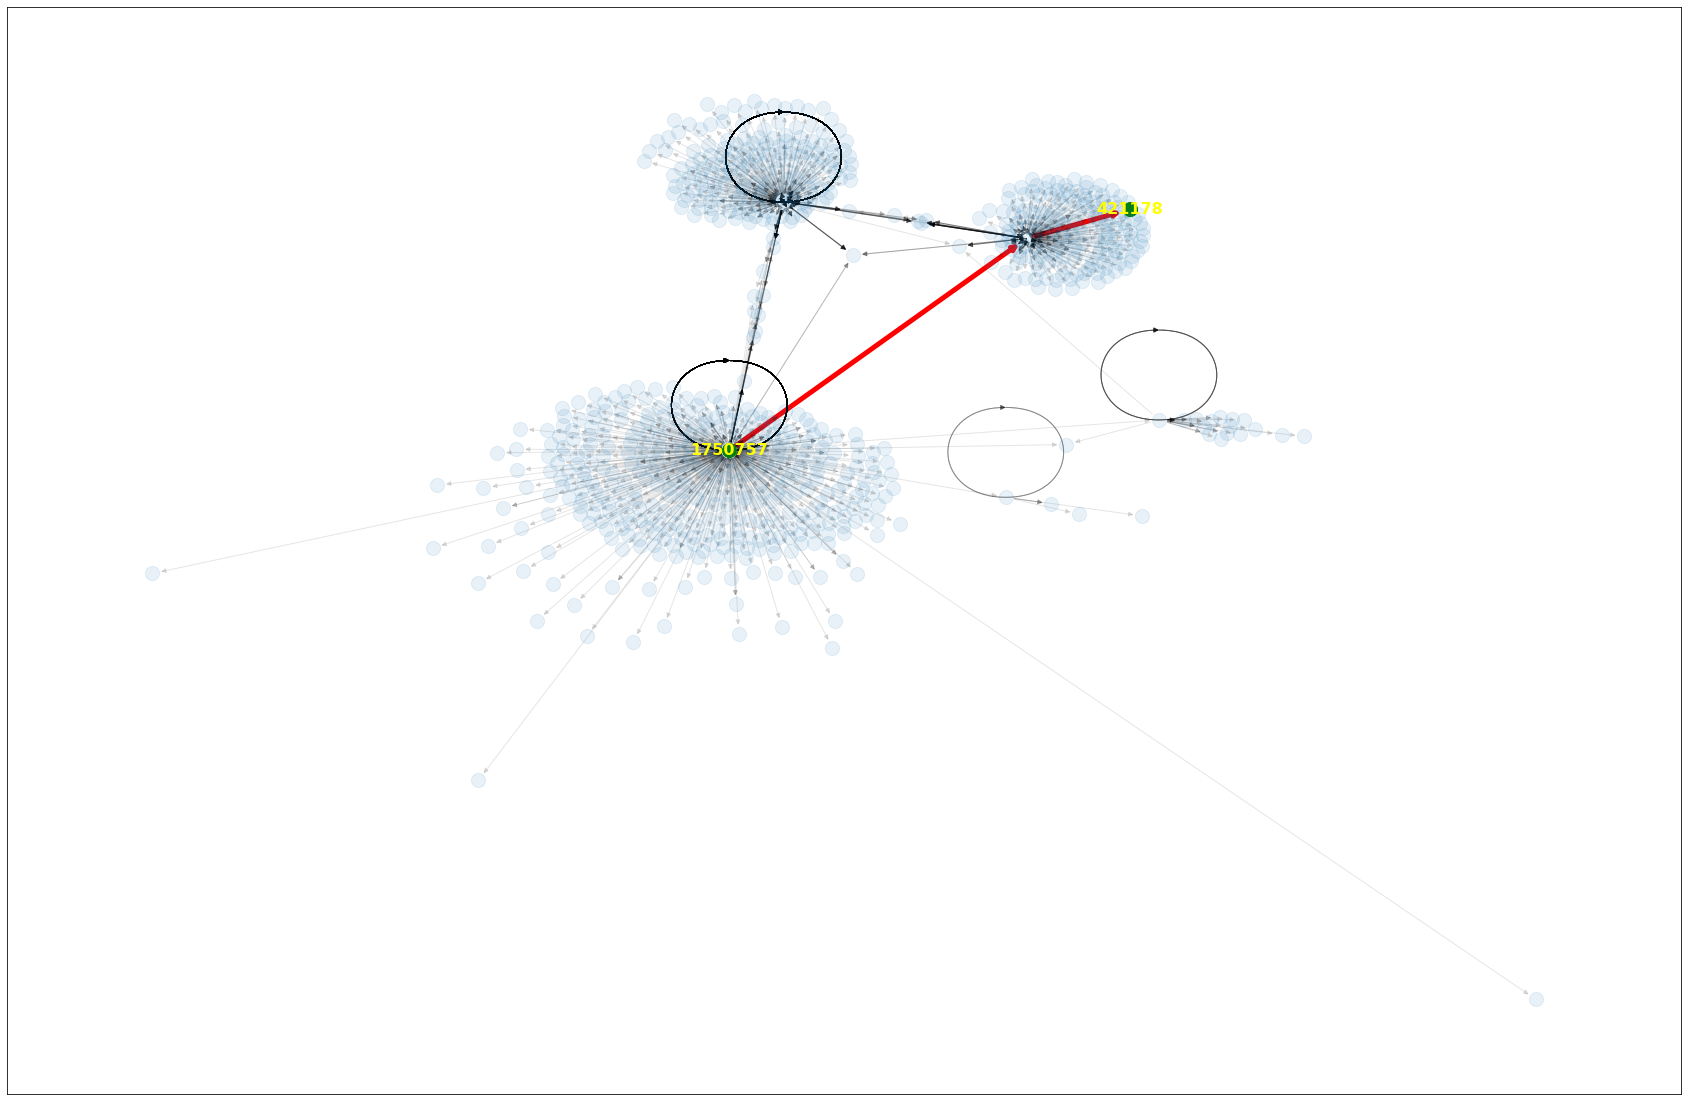

In [52]:
path, min_distances = dijkstra(start_node=1750757,
                               end_node=421178,
                               gr=subg)

Then, for our actual functionality 3, we collect the shortest path for each pair of nodes we need to visit and the return the overall path. We also plot a zoomed-in version of the subgraph highlightining the edges and the nodes that are included in the path.

In [87]:
def functionality_3(start_date:str, end_date:str, start_node:int, end_node:int, intermediate_nodes:list):
    """
    Summary:
        From the start and end date this function first create a subgraph containing only edges representing
        interactions that took place within that time frame. Then it find the shortest path between start_node
        and end_node that passes through all the intermediate_nodes.
    
    Args:
        start: string of date from which we want to filter entries.
        end: string of date up to which we want to filter entries.
        start_node: node from which we have to find the shortest path.
        end_node: node to which we have to find the shortest path.
        intermediate_nodes: nodes that we have to visit between start_node and end_node
    """
    df_g1 = get_df_for_time_interval(start_date, end_date, dfs, names)
    subg_1 = get_subgraph_from_df(df=df_g1)
    node_a = start_node
    intermediate_counter = 0
    edges = []
    
    while node_a != end_node:
        if intermediate_counter < len(intermediate_nodes):
            node_b = intermediate_nodes[intermediate_counter]
        else:
            node_b = end_node
        path, _ = dijkstra(node_a, node_b, subg_1, visualization=False)
        edges = edges + path
        node_a = node_b
        intermediate_counter += 1
    
    nodes_of_interest = [start_node] + [end_node] + intermediate_nodes
    zoomed_in = get_zoomed_graph(subg_1, nodes_of_interest)
    visualize_network(zoomed_in, 
                      edges_to_highlight=edges, 
                      nodes_to_highlight=nodes_of_interest,
                      nodes_to_label=[start_node, end_node],
                      label_c="black")
    print(edges)

Here, we can se an example of the output:

start: 2015-06-13 11:00:00
end: 2015-06-13 18:00:00


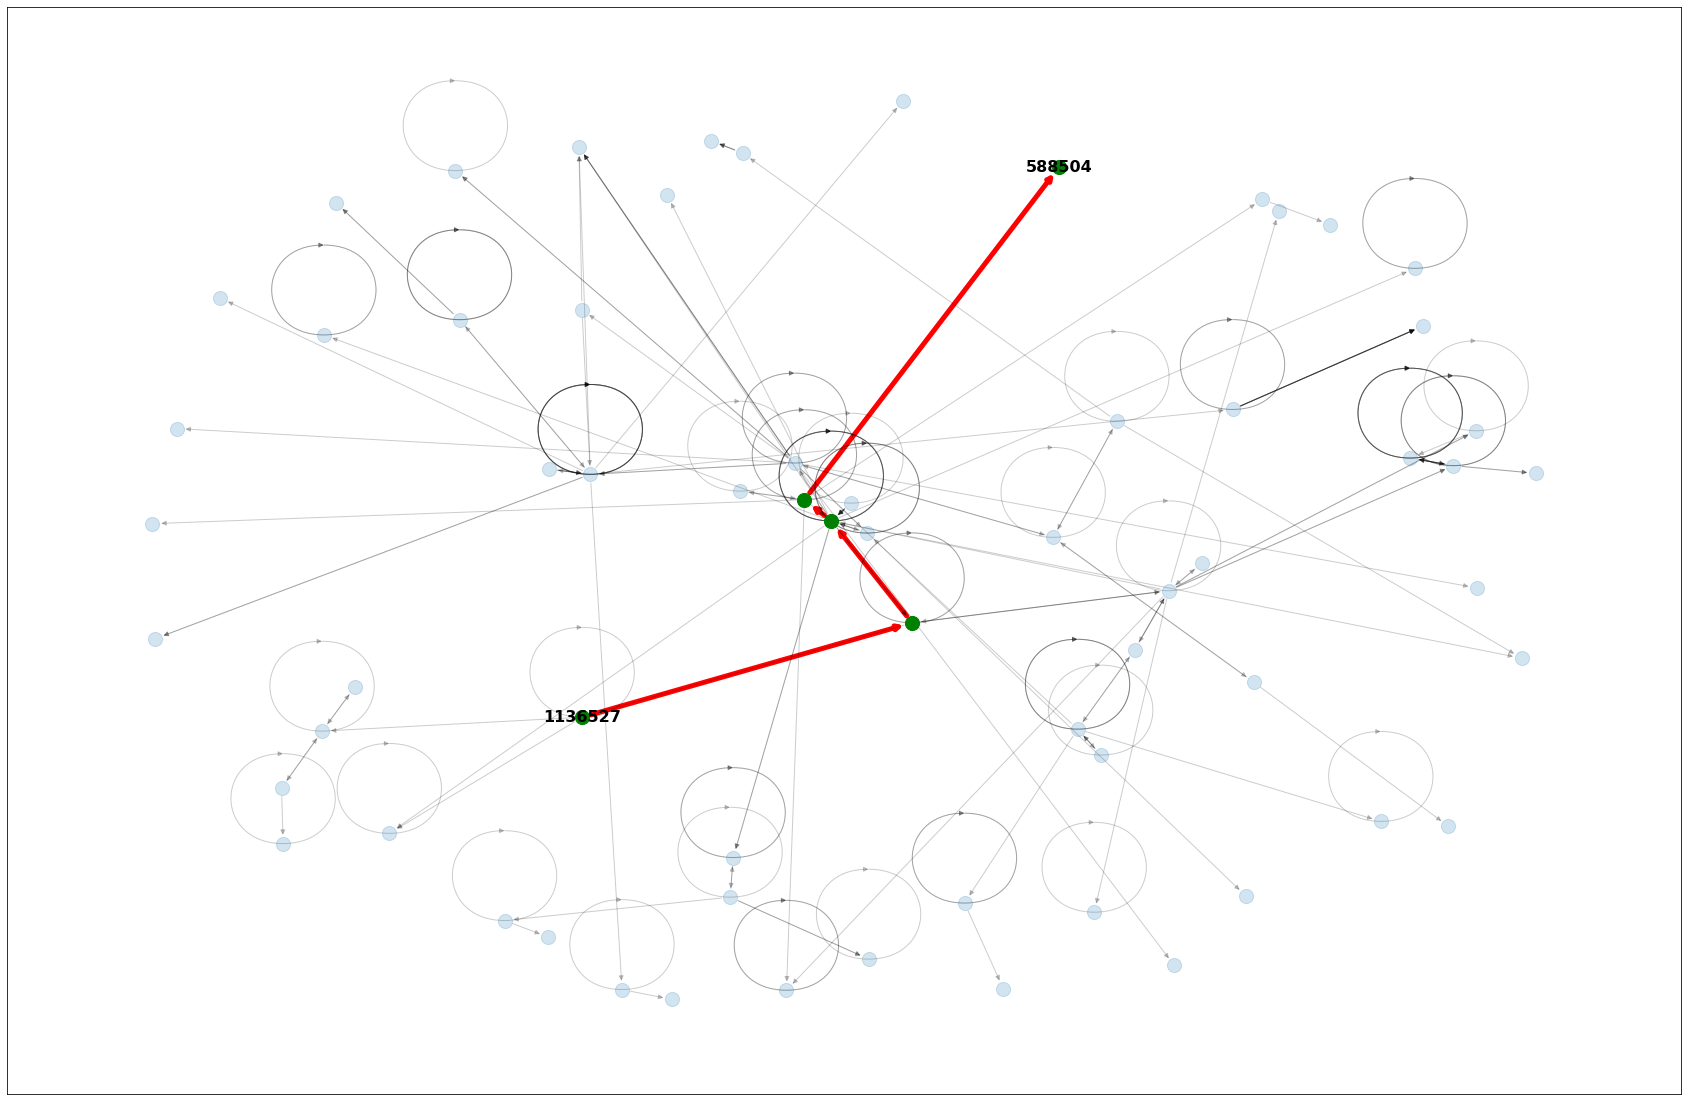

[(1136527, 4832823), (4832823, 3117575), (3117575, 1717734), (1717734, 588504)]


In [46]:
# start_node=1136527, end_node=4735501, intermediate_nodes=[693560, 1947199]
start = "2015-06-13 11:00:00"
end = "2015-06-13 18:00:00"
functionality_3(start, end, 1136527, 588504, [4832823, 3117575, 1717734])

## Functionality 4

First, we created a ***get_df_for_time_interval*** function that allows for quick retrieval of the edges for a specific time interval. It takes as input the dataframes containing the information for each stackoverflow interaction and filters them according to the given start and end date.<br><br>
Once we have those information, we build the relevant subgraph with ***get_subgraph_from_df***.<br><br>
For our actual ***disconnect_nodes function***, we simply execute the dijkstra algorithm over and over between the two nodes and each time we remove the cheapest link. When there are no more possible paths between the two nodes, it means that we've succesfully disconnected them.<br><br>

In [34]:
def get_df_for_time_interval(start:str, end:str, dfs:pd.DataFrame, names:list):
    
    """
    Summary:
        returns a subset of the dataframes given in input containing all the interactions 
        relevant for a given time frame.
    
    Args:
        start: string of date from which we want to filter entries.
        end: string of date up to which we want to filter entries.
        dfs: dataframes to use to collect the data.
        names: names of the dataframes.
    """
    
    start = parse(start)
    end = parse(end)
    print(f"start: {start}")
    print(f"end: {end}")
    
    subdfs = []
    
    for i, df in enumerate(dfs):
        sub_df = df[df["time_h"] >= start]
        sub_df = sub_df[sub_df["time_h"] < end]
        sub_df.columns = ["user_a", "user_b", "time_h", "weight"]
        sub_df["type"] = names[i]
        subdfs.append(sub_df)
    
    return pd.concat(subdfs, axis=0)


def get_subgraph_from_df(df:pd.DataFrame):
    
    """Summary: 
            builds a graph from the dataframe provided in input. 
            The graph is a dictionary with the structure:
    
            graph -> Our entire graph, indexed by node
            graph[node "A"] -> dictionary indexed by the neighbors of "A"
            self.graph[node "A"][node "B"] -> dictionary indexed by the time the interation took place
            self.graph[node "A"][node "B"][time "x"] -> details (specifically, type of interaction and edge weight) of the
                                                        of the interaction between user A and B that took place at time x 
        
        Args:
            df: Pandas Dataframe containing the information for each node
    """
    
    subg = {}
    nodes = np.unique(df["user_a"].values)
    for node in nodes:
        
        if node not in subg.keys():
            subg[node] = {}
        
        subdf = df[df["user_a"]==node]
        neighs = subdf["user_b"].values
        times = subdf["time_h"].values
        weights = subdf["weight"].values
        type_of_interaction = subdf["type"].values
        
        for i, neigh in enumerate(neighs):
            if neigh not in subg.keys():
                subg[neigh] = {}
            if neigh not in subg[node].keys():
                subg[node][neigh] = {}
            subg[node][neigh][times[i]] = {"weight": weights[i], 
                                           "type_of_interaction": type_of_interaction[i]}
        
    return subg


def disconnect_nodes(subg:dict, node_1:int, node_2:int):
    """
    Summary:
        Given a subgraph subg, it disconnects node_1 and node_2 progressively removing 
        the cheapest edges connecting them.
    
    Args:
        subg: the subgraph containing the nodes we want to disconnect.
        node_1: the first node we want to disconnect.
        node_2: the second node we want to disconnect.
    """
    
    removed_edges = []
    shortest_path = [node_1]
    shortest_path, distances_m = dijkstra(start_node=node_1, end_node=node_2, gr=subg, visualization=False)
    
    while len(shortest_path) > 0:
        print(shortest_path)
        cheapest_value = np.inf
        candidate_edge = (None, None)
        
        node_b = node_2
        
        while node_b != node_1:
            value, node_a = distances_m[node_b]
            if value < cheapest_value:
                candidate_edge = (node_a, node_b)
            node_b = node_a
                
        removed_edges.append(candidate_edge)
        subg[candidate_edge[0]].pop(candidate_edge[1])
        
        shortest_path, distances_m = dijkstra(start_node=node_1, end_node=node_2, gr=subg, visualization=False)
    
    print(f"Minimum number of edges to disconnect: {len(removed_edges)}")
    return removed_edges


def get_zoomed_graph(gr:dict, nodes_of_interest:list, max_extra_nodes:int = 100):
    """
    Summary:
        Obtains a close up of the graph with respect to the nodes of interest.
    
    Args:
        gr: a dictionary representing the graph we want to zoom in.
        nodes_of_interest: the nodes we want to zoom in to.
        max_extra_nodes: the number of nodes beside the nodes of interest and their neighbors that we
                         want to include in the zoomed in representation.
    """
    subg = {}
    to_check = list(nodes_of_interest)
    i = 0
    extra_nodes_counter = 0
    while i < len(to_check):
        node = to_check[i]
        if node not in subg.keys():
            subg[node] = {}        
        for neigh in gr[node].keys():
            if neigh not in subg.keys():
                subg[neigh] = {}
            if neigh not in to_check:
                to_check.append(neigh)
            subg[node][neigh] = dict(gr[node][neigh])
            
            if node not in nodes_of_interest:
                if extra_nodes_counter < max_extra_nodes:
                    extra_nodes_counter += 1
                else:
                    return subg
        i += 1
    return subg

Lastly, our ***functionality_4*** performs all the steps we mentioned above and plots a zoomed-in visual representation of the edges that have been removed.

In [314]:
def functionality_4(start_date, end_date, node_a, node_b):
    """
    Summary:
        Given a time frame and two nodes, this function disconnects the two nodes and provides a visual representation
        of the edges that are removed.
    
    Args:
        start_date: beginning of time frame.
        end_date: end of time frame.
        node_a: first node to disconnect.
        node_b: second node to disconnect.
    """
    
    df_g1 = get_df_for_time_interval(start_date, end_date, dfs, names)
    subg_1 = get_subgraph_from_df(df=df_g1)
    to_remove = disconnect_nodes(subg_1, node_a, node_b)
    print(to_remove)
    nodes_of_interest = []
    for edge in to_remove:
        for node in edge:
            if node not in nodes_of_interest:
                nodes_of_interest.append(node)
    zoomed_in = get_zoomed_graph(subg_1, nodes_of_interest)
    visualize_network(zoomed_in, to_remove, nodes_to_highlight=[node_a, node_b], nodes_to_label=[node_a, node_b],
                     label_c="black")

start: 2015-06-10 10:00:00
end: 2015-06-10 16:00:00
[(267, 1480090)]
[(267, 3970411), (3970411, 1480090)]
No path found.
Minimum number of edges to disconnect: 2
[(267, 1480090), (267, 3970411)]


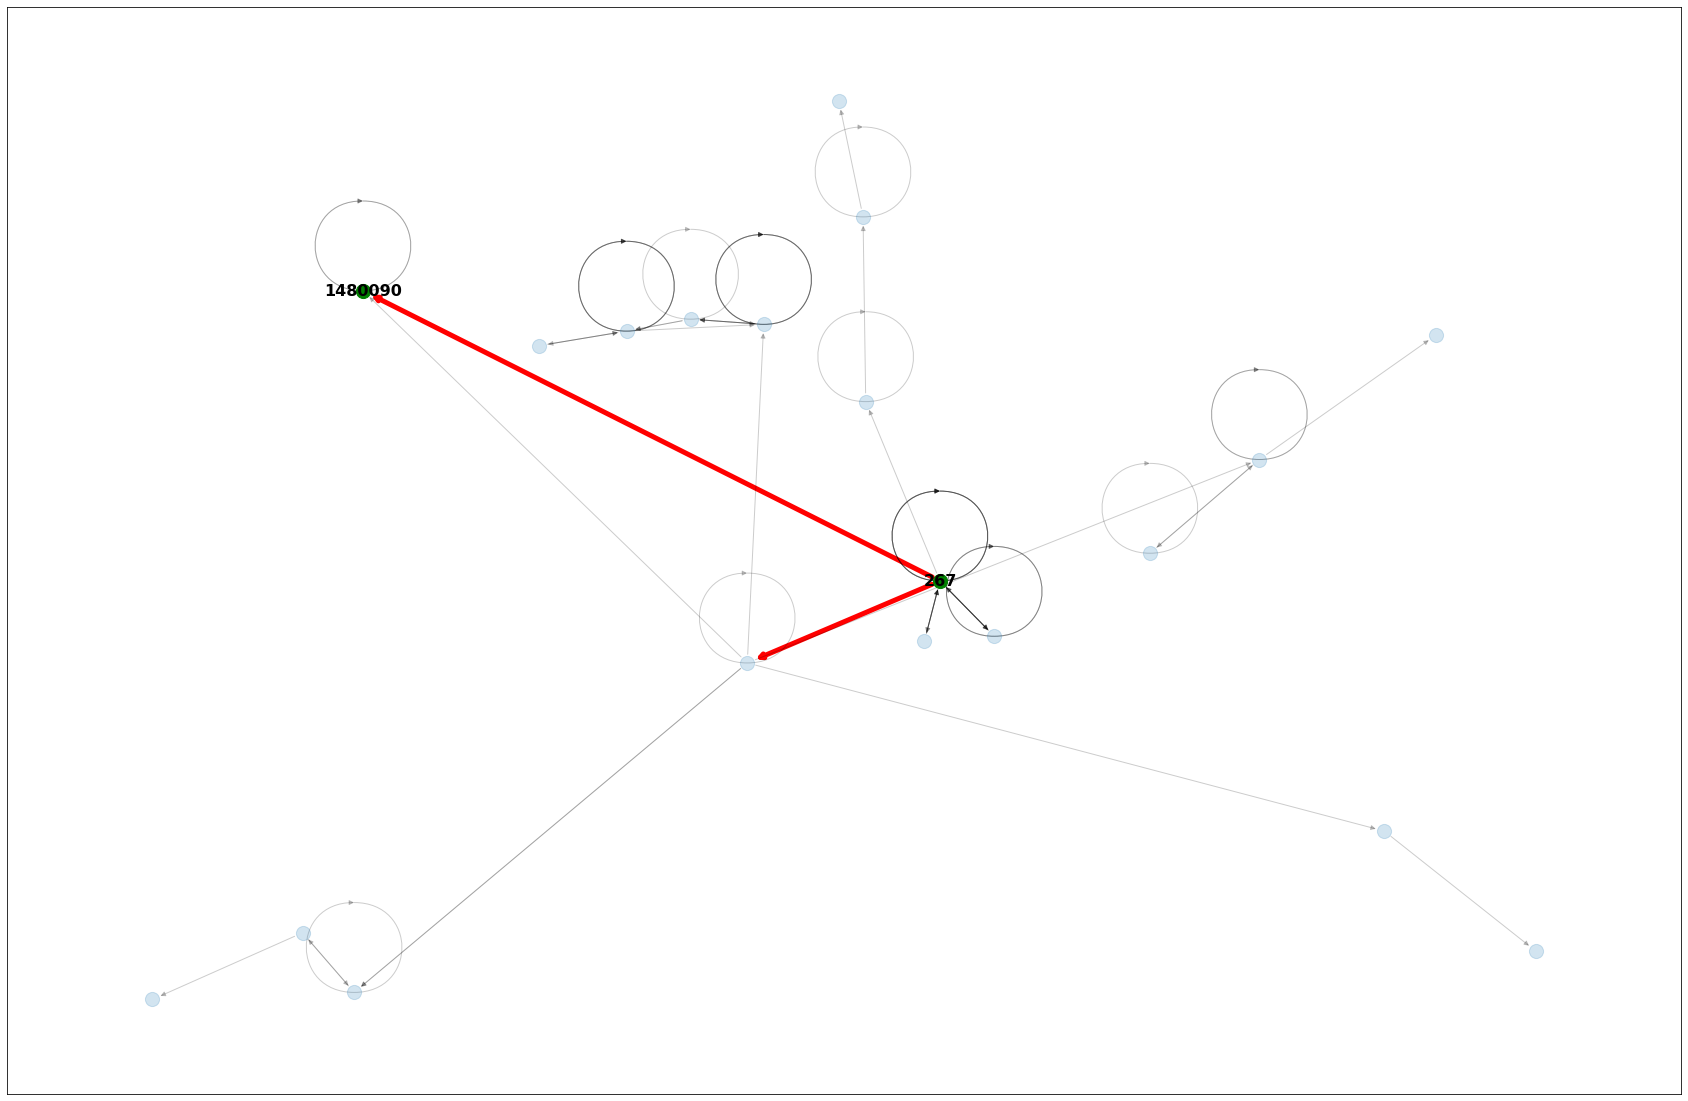

In [315]:
start = "10 June 2015 10:00:00"
end = "10 June 2015 16:00:00"
functionality_4(start_date=start,
                end_date=end,
                node_a=267,
                node_b=1480090)

## User interface

In [327]:
def user_interface():
    
    def custom_or_demo_getter():
        user_input = input("Enter \"custom\" if you want to enter custom values\n" +
                           "Enter \"demo\" if you want to see a demo:\n")
        return user_input
    
    selection = 0
    print("Here's a list of the available functions:\n\n"
          "Function 1: Overall features of graph\n"
          "Function 2: Best user\n"
          "Function 3: Shortest ordered route\n"
          "Function 4: Disconnect nodes")
    print("*"*40)
    
    while selection != "q":
        selection = input("Select the number of the function (q to exit): ")
        print()
        
        if selection == "1":
            print("You want to retrieve the overall features of the graph.\n")
            overallFeatures(g)
            
        elif selection == "2":
            print("You want to find the best user.\n")
            metric = input("Which metric do you choose?\n")
            if metric not in ['Betweenness', 'PageRank', 'DegreeCentrality', 'ClosenessCentra']
            c_or_d = custom_or_demo_getter()
            
            if custom_or_demo.lower() == "custom":
                start_date = input("From which date do you want the nodes to be (month, day, year)? " )
                end_date = input("Up to which date do you want the nodes to be (month, day, year)? ")
                user = int(input("Node you want to investigate?: "))
                
            elif custom_or_demo.lower() == "demo":
                start_date = "2014-10-03"
                end_date = "2014-10-15"
                user = 981959
            
            else:
                print("Selection not valid.")
                break
            
            time = (start_date, end_date)
            node_score = functionality_2(user, time, metric)
            text = "User {} has a centrality score of {} for {} metric"
            print(text.format(user, node_score, metric))
            visualization_2(user, time, metric)
        
        elif selection == "3":
            print("You want to find the shortest ordered route.\n")
            custom_or_demo = custom_or_demo_getter()
            
            if custom_or_demo.lower() == "custom":
                start_date = input("From which date do you want the nodes to be (month, day, year, time)? " )
                end_date = input("Up to which date do you want the nodes to be (month, day, year, time)? ")
                start_node = int(input("Node you want to start from?: "))
                end_node = int(input("Node you want to get to?: "))
                intermediate_nodes = input("Nodes you want to visit?(space-separated): ")
                intermediate_nodes = list(map(int, intermediate_nodes.split(" ")))
                print(intermediate_nodes)
                
            elif custom_or_demo.lower() == "demo":
                start_date = "2015-06-13 11:00:00"
                end_date = "2015-06-13 18:00:00"
                start_node = 1136527
                end_node = 588504
                intermediate_nodes = [4832823, 3117575, 1717734]
            
            else:
                print("Selection not valid.")
                break
                
            functionality_3(start_node=start_node, 
                            end_node=end_node,
                            intermediate_nodes=intermediate_nodes,
                            start_date=start_date,
                            end_date=end_date)
            
        elif selection == "4":
            print("You want to disconnect two nodes.\n")
            custom_or_demo = custom_or_demo_getter()
            if custom_or_demo.lower() == "custom":
                start_date = input("From which date do you want the nodes to be (month, day, year, time)? " )
                end_date = input("Up to which date do you want the nodes to be (month, day, year, time)? ")
                node_a = input("First node you want to disconnect? ")
                node_b = input("Second node you want to disconnect? ")
                
            elif custom_or_demo.lower() == "demo":
                start_date= "10 June 2015 10:00:00"
                end_date = "10 June 2015 16:00:00"
                node_a=267
                node_b=1480090
            
            else:
                print("Selection not valid.")
                break
                
            functionality_4(start_date=start_date,
                            end_date=end_date,
                            node_a=int(node_a),
                            node_b=int(node_b))
                            
        elif selection != "q":
            print("Selection not valid.")
    

Here's a list of the available functions:

Function 1: Overall features of graph
Function 2: Best user
Function 3: Shortest ordered route
Function 4: Disconnect nodes
****************************************
Select the number of the function (q to exit): 3

You want to find the shortest ordered route.

Enter "custom" if you want to enter custom values
Enter "demo" if you want to see a demo:
custom
From which date do you want the nodes to be (month, day, year, time)? 2015-06-13 11:00:00
Up to which date do you want the nodes to be (month, day, year, time)? 2015-06-13 18:00:00
Node you want to start from?: 1136527
Node you want to get to?: 588504
Nodes you want to visit?(Space-separated): 4832823 3117575 1717734
[4832823, 3117575, 1717734]
start: 2015-06-13 11:00:00
end: 2015-06-13 18:00:00


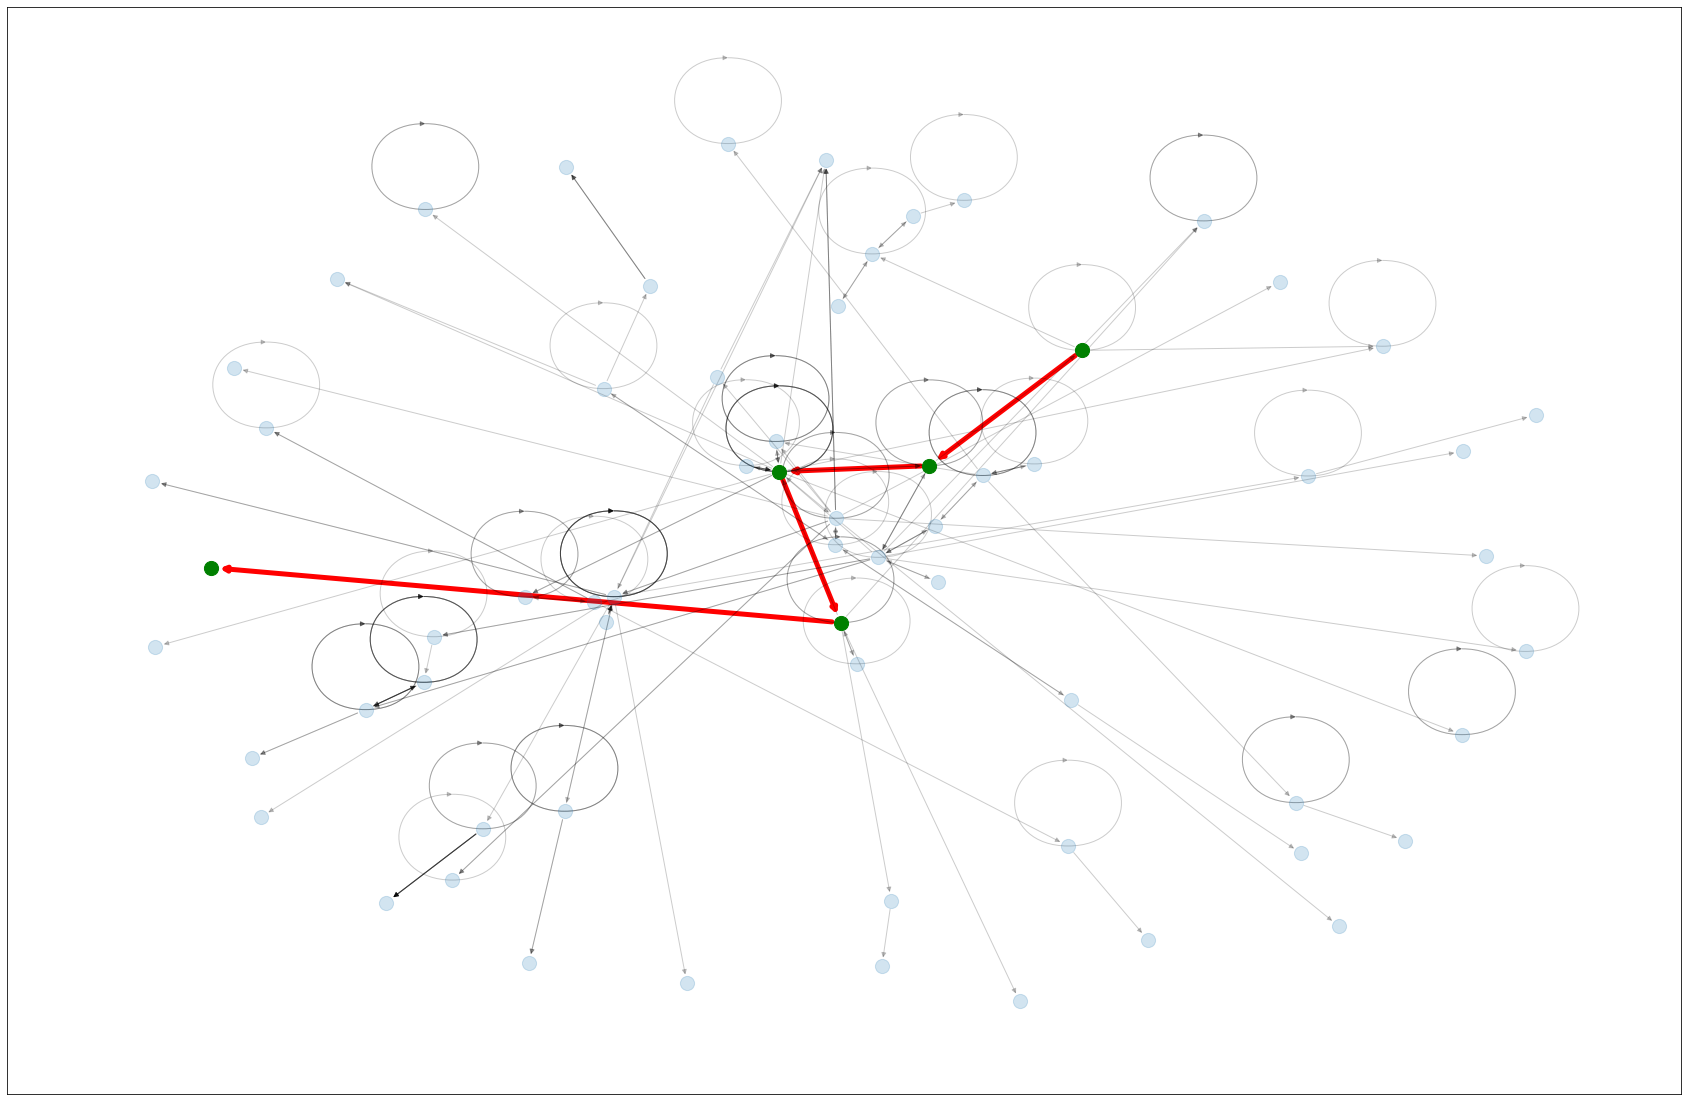

[(1136527, 4832823), (4832823, 3117575), (3117575, 1717734), (1717734, 588504)]
Select the number of the function (q to exit): q



In [328]:
user_interface()

# 4. Algorithmic question

A number n of kids are in a camp. Between some k pairs of them (a kid can be part of more than one pairs) there are often fights. At night there are two dormitories where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory. (There are no space problems and the two dormitories can have different number of kids.)

Give an algorithm that is linear in n and k that is able to answer whether such an assignment is possible and, if so, return one.

### Answer:
Let in a first time see how we could represent such a problem. <br />
This problem could easily represent such a problem with a graph each kid would be a Vertex and each pair would be a vertex. If such a rep is done we could use an adaptation of the BFS to solve this problem. We know from the course that the complexity of such an algorithm is O(n, k) = 2|k| thus it is linear. <br />
The algorithm would be the following. <br />
In this pseudocode I suppose that every edges know there neigboors and they have a value d initialize at 0 (Normaly use for the distance) and the value 1 or 2 will be assign to them (idicate the dormitory). An other modification will be the Use of a BinaryQueue instead of Queue. The principle of such a data type is to have two queu on who have priorities and the other one when we push the element into the BinaryQueue we choose to assigne it to one of this queu and when we dequeue it will first look in the priority queue and if it is empty it will go to the second queue. This modification is needed as we do not know if the graph is conected and in the case where he is not we do not know the different component of the graph the solution. <br />
<br />
d1 = list()<br />
d2 = list()<br />
n = list()<br />
q = BinaryQueu()<br />
q.push2(n)<br />
while(not q.isEmpty()):<br />
&nbsp;&nbsp;&nbsp;&nbsp; e = q.dequeue()<br />
&nbsp;&nbsp;&nbsp;&nbsp; if e.d == 0:<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;e.d = 1<br />
&nbsp;&nbsp;&nbsp;&nbsp; for neighbour in e:<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;if neighbour.d == 0 :<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;if e.d == 2 <br /> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;neighbour.d = 1 <br/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; d1.add(neighbour)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;else <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;neighbour.d = 2<br/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; d2.add(neighbour)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; q.push1(neighbour) <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;elif e.d == neighbour.d <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; print(imposible)<br />
<br />
As we could see the fact that we are using a BinaryQueue will add k to our complexity as we will check as the nodes one more to be sure that all the component of the graph have been seen

In [79]:
# For this question we use some personal DS as BinaryQueu and Edges
from DataStructure import BinaryQueue, Edges
import numpy as np

# Max kid
n_k = 20
kids = [Edges(i) for i in range(n_k)] # genreate 20 kid
d1 = list()
d2 = list()
n_enemy = 100
n = np.random.randint(0, n_k,(n_enemy, 2)) # Generate the k pair
# create the network in O(k) = |k|
for i in range(len(n)):
    i1 = n[i][0]
    i2 = n[i][1]
    if i1 != i2: 
        k1 = kids[i1]
        k2 = kids[i2]
        k1.add(k2)
        k2.add(k1)
# apply the BFS in O(k) = 3|k|  in our case      
q = BinaryQueue()
for k in kids:
    q.push2(k)
while not q.empty():
    e = q.dequeue()
    if e.d == 0:
        e.d = 1
        d1.append(e)
    for neigboor in e.neighbours:
        if neigboor.d == 0:
            neigboor.assignd(e, d1, d2)
            q.push1(neigboor)
        elif neigboor.d == e.d:
            print("impossible", e, neigboor)
            q.clear()
            break
print(d1)
print(d2)
print(kids[0], kids[0].neighbours)

impossible 3 19
[0, 1, 2]
[16, 9, 15, 12, 10, 8, 6, 13, 3, 11, 18, 19, 14, 17, 4]
0 [16, 9, 15, 12, 10, 8, 6, 13, 3, 16, 12]
